# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


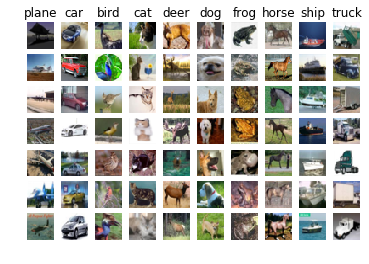

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


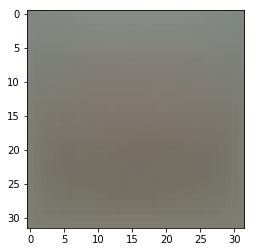

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.967224


In [8]:
print('Data shape X', X_dev.shape)
print('Labels shape y',y_dev.shape)
print('Augmented eeights shape W', W.shape)

X = X_dev
y = y_dev

Data shape X (500, 3073)
Labels shape y (500,)
Augmented eeights shape W (3073, 10)


In [9]:
len(y)

500

In [10]:
S = X.dot(W)
S
# scores = X[1].dot(W)
# scores
S.shape

(500, 10)

In [11]:
# build mask selecting only the correct classes (one-hot encodig of y_i)
mask = np.eye(W.shape[1], dtype=bool)[y] 

# Alternative: mask = np.eye(W.shape[1])[y]  # for floats

print('mask shape', mask.shape)
mask

mask shape (500, 10)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [12]:

correct_scores_vec = np.sum(np.where(mask, S, 0), axis=1)
correct_scores = correct_scores_vec[:,np.newaxis]
print('correct_scores.shape', correct_scores.shape)
# correct_scores

correct_scores.shape (500, 1)


In [13]:
print('S.shape', S.shape)

M = S - correct_scores + 1
M[mask] = 0
# M[200]

S.shape (500, 10)


In [14]:
pM = np.where(M>0, M, 0)
print('pM.shape', pM.shape)
pM[0]

pM.shape (500, 10)


array([1.47098267, 1.86537609, 0.82130506, 1.10468765, 1.40983769,
       1.30058101, 0.        , 1.56460786, 1.68307332, 1.14489238])

In [15]:
dpM = np.zeros((X.shape[0], W.shape[1]))  # 500 x 10 zeros
# we'll store here two contributions that we later multiply by X.T
# to compute dW = X.T.dot(dpM)

In [16]:
# first contributoin (all active margins for others)
pMactive = np.where(M>0, 1, 0)
print('pMactive.shape', pMactive.shape)
dpM += pMactive


pMactive.shape (500, 10)


In [17]:
# second contributoin subtract fro self self sum of others active
dpM[mask] = -1*np.sum(pMactive, axis=1)


In [18]:
dW = X.T.dot(dpM)
dW

array([[-2.79576455e+03, -4.73975649e+03,  4.31588541e+03, ...,
        -1.00716204e+02, -8.47081020e+03, -1.91438174e+04],
       [-6.78587663e+03, -3.82380367e+03,  2.55117806e+03, ...,
         2.45596347e+03, -1.53748265e+04, -2.17716028e+04],
       [-1.24100400e+04, -4.08514759e+03,  6.63532633e+03, ...,
         4.14894784e+03, -2.73976082e+04, -2.83103607e+04],
       ...,
       [-3.63139502e+03, -8.29907380e+03, -5.12921184e+03, ...,
        -2.34276082e+02,  6.85919592e+03, -6.67655535e+03],
       [-5.79732671e+03, -1.28874189e+04, -1.51301929e+03, ...,
         5.73479914e+03, -4.38904286e+03, -9.90681414e+03],
       [ 1.71000000e+02, -4.40000000e+01, -4.50000000e+01, ...,
        -2.00000000e+00, -1.00000000e+02, -3.30000000e+01]])

In [19]:
pMmask = np.where(M>0, 1, 0)
pMmask

np.sum(1*pMmask, axis=1)

array([9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 8,
       8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 9, 9, 9, 9, 9, 8,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 8, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 9, 9, 9, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9,

In [21]:
dW1 = X.T.dot(1*~pMmask)

print('dW1.shape', dW1.shape)
dW1

dW1.shape (3073, 10)


array([[3057.86393878, 3628.10028571, 3245.8164898 , ..., 3165.59357143,
        3509.47181633, 5219.38408163],
       [2113.44704082, 2144.86714286, 2024.90367347, ..., 1516.73928571,
        2800.14112245, 4068.83061224],
       [ 780.43555102,  518.53542857,  -87.41240816, ..., -431.14714286,
        2311.42665306, 2965.48326531],
       ...,
       [4659.34277551, 5096.51771429, 5332.79379592, ..., 4332.55142857,
        3363.58832653, 5090.24163265],
       [5071.98814286, 5908.798     , 5417.99885714, ..., 4072.595     ,
        4940.80442857, 5714.59714286],
       [-961.        , -938.        , -936.        , ..., -945.        ,
        -923.        , -940.        ]])

In [22]:
sum_dW1 = np.sum(dW1, axis=1)
sum_dW1.shape


(3073,)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [23]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print('---')

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.285066 analytic: -4.285279, relative error: 2.487055e-05
numerical: 2.510772 analytic: 2.510970, relative error: 3.940164e-05
numerical: 10.521487 analytic: 10.521385, relative error: 4.846043e-06
numerical: -7.591678 analytic: -7.591468, relative error: 1.382773e-05
numerical: 14.543232 analytic: 14.543571, relative error: 1.164073e-05
numerical: 39.645698 analytic: 39.645759, relative error: 7.734647e-07
numerical: -2.741497 analytic: -2.741695, relative error: 3.618755e-05
numerical: -3.849402 analytic: -3.849249, relative error: 1.990127e-05
numerical: 1.206567 analytic: 1.206753, relative error: 7.680051e-05
numerical: 22.665671 analytic: 22.665491, relative error: 3.981718e-06
---
numerical: -35.022629 analytic: -34.997936, relative error: 3.526548e-04
numerical: -10.328849 analytic: -10.323788, relative error: 2.450321e-04
numerical: 12.358339 analytic: 12.354499, relative error: 1.553801e-04
numerical: -25.942305 analytic: -25.959946, relative error: 3.398839e-04


**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$  step size 


In [24]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.967224e+00 computed in 0.172695s
Vectorized loss: 8.967224e+00 computed in 0.006436s
difference: 0.000000


In [25]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.167425s
Vectorized loss and gradient: computed in 0.003964s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [30]:
num_train, dim = X.shape
num_train

500

In [35]:
np.random.choice(np.arange(num_train), size=3)

array([  7, 213, 395])

In [58]:
scores = X.dot(W)
np.argmax(scores, axis=1)

array([1, 8, 8, 1, 4, 9, 8, 0, 5, 8, 1, 9, 2, 5, 8, 7, 2, 8, 8, 4, 2, 8,
       7, 2, 1, 1, 1, 9, 9, 2, 2, 4, 5, 2, 6, 3, 2, 5, 9, 2, 4, 8, 4, 6,
       0, 3, 6, 8, 2, 6, 4, 2, 0, 8, 0, 9, 8, 2, 1, 3, 5, 8, 8, 6, 9, 1,
       7, 2, 0, 3, 5, 3, 3, 9, 2, 7, 0, 1, 9, 0, 8, 2, 2, 0, 2, 8, 4, 0,
       2, 8, 4, 2, 3, 8, 7, 2, 5, 9, 9, 2, 8, 3, 8, 7, 8, 0, 2, 8, 7, 5,
       0, 2, 8, 1, 4, 5, 7, 0, 2, 4, 5, 2, 4, 2, 4, 3, 2, 7, 2, 8, 6, 2,
       7, 0, 1, 2, 7, 4, 3, 8, 9, 5, 8, 3, 5, 6, 1, 7, 2, 8, 5, 9, 8, 9,
       9, 7, 2, 0, 7, 9, 3, 8, 3, 7, 2, 7, 5, 6, 3, 0, 7, 3, 0, 8, 5, 1,
       6, 8, 9, 2, 8, 6, 6, 7, 1, 2, 1, 5, 0, 1, 8, 7, 3, 9, 9, 3, 8, 9,
       5, 4, 4, 9, 2, 2, 4, 5, 2, 7, 2, 2, 7, 9, 9, 4, 9, 2, 6, 9, 1, 7,
       9, 1, 3, 4, 6, 0, 5, 9, 9, 7, 8, 9, 9, 3, 9, 0, 5, 1, 3, 3, 2, 9,
       1, 9, 8, 0, 0, 5, 4, 5, 2, 1, 7, 6, 1, 0, 7, 4, 9, 8, 5, 2, 9, 8,
       1, 5, 5, 1, 6, 8, 4, 3, 2, 3, 2, 3, 6, 2, 2, 0, 4, 2, 0, 7, 8, 9,
       9, 9, 5, 3, 4, 2, 5, 0, 2, 1, 9, 3, 2, 8, 0,

In [49]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=8e-7, reg=2.5e4,
                      num_iters=2500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 2500: loss 790.353719
iteration 100 / 2500: loss 757.429746
iteration 200 / 2500: loss 744.517703
iteration 300 / 2500: loss 735.270457
iteration 400 / 2500: loss 726.730818
iteration 500 / 2500: loss 719.414560
iteration 600 / 2500: loss 713.690971
iteration 700 / 2500: loss 707.872447
iteration 800 / 2500: loss 702.697026
iteration 900 / 2500: loss 698.539866
iteration 1000 / 2500: loss 694.881811
iteration 1100 / 2500: loss 689.557285
iteration 1200 / 2500: loss 686.639044
iteration 1300 / 2500: loss 683.265046
iteration 1400 / 2500: loss 679.982727
iteration 1500 / 2500: loss 676.256880
iteration 1600 / 2500: loss 674.317409
iteration 1700 / 2500: loss 671.382462
iteration 1800 / 2500: loss 668.714053
iteration 1900 / 2500: loss 666.212855
iteration 2000 / 2500: loss 664.259143
iteration 2100 / 2500: loss 661.774851
iteration 2200 / 2500: loss 659.239398
iteration 2300 / 2500: loss 658.399170
iteration 2400 / 2500: loss 655.528033
That took 6.466095s


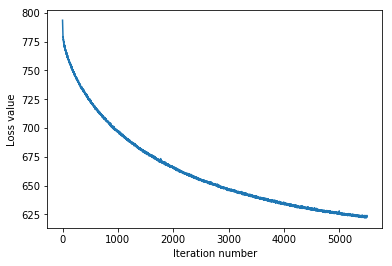

In [48]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [59]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.374184
validation accuracy: 0.358000


In [75]:
from cs231n.classifiers import LinearSVM
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
#   - keys (learning_rate, regularization_strength)
#   - vals (training_accuracy, validation_accuracy).
# The accuracy is the fraction of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [5e-7, 8e-7, 9e-7, 1e-6, 1e-5]
regularization_strengths = [5e4, 8e4, 1e5]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

print("Starting hyperparameter search...")
NUM_ITERATIONS = 5000

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train, y_train,
                              learning_rate=lr,
                              reg=reg,
                              num_iters=NUM_ITERATIONS, verbose=False)
        toc = time.time()
        print('Training  took %fs' % (toc - tic), '  lr=', lr, '   reg=', reg)
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        # print('training accuracy: %f' % (training_accuracy, ))
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        # print('validation accuracy: %f' % validation_accuracy)

        results[(lr,reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Starting hyperparameter search...
Training  took 11.688527s   lr= 5e-07    reg= 50000.0
Training  took 11.941359s   lr= 5e-07    reg= 80000.0
Training  took 12.058511s   lr= 5e-07    reg= 100000.0
Training  took 12.228965s   lr= 8e-07    reg= 50000.0
Training  took 12.630782s   lr= 8e-07    reg= 80000.0
Training  took 12.411768s   lr= 8e-07    reg= 100000.0
Training  took 12.445779s   lr= 9e-07    reg= 50000.0
Training  took 12.661554s   lr= 9e-07    reg= 80000.0
Training  took 13.074929s   lr= 9e-07    reg= 100000.0
Training  took 13.538837s   lr= 1e-06    reg= 50000.0
Training  took 12.756568s   lr= 1e-06    reg= 80000.0
Training  took 12.322161s   lr= 1e-06    reg= 100000.0
Training  took 12.290402s   lr= 1e-05    reg= 50000.0
Training  took 13.431025s   lr= 1e-05    reg= 80000.0
Training  took 12.798033s   lr= 1e-05    reg= 100000.0
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.394898 val accuracy: 0.380000
lr 5.000000e-07 reg 8.000000e+04 train accuracy: 0.390102 val accuracy

In [78]:
results

{(5e-07, 50000.0): (0.3948979591836735, 0.38),
 (5e-07, 80000.0): (0.39010204081632655, 0.367),
 (5e-07, 100000.0): (0.393, 0.363),
 (8e-07, 50000.0): (0.39040816326530614, 0.367),
 (8e-07, 80000.0): (0.39393877551020406, 0.36),
 (8e-07, 100000.0): (0.3895918367346939, 0.372),
 (9e-07, 50000.0): (0.40577551020408165, 0.382),
 (9e-07, 80000.0): (0.3901428571428571, 0.362),
 (9e-07, 100000.0): (0.39471428571428574, 0.355),
 (1e-06, 50000.0): (0.37789795918367347, 0.371),
 (1e-06, 80000.0): (0.3846326530612245, 0.361),
 (1e-06, 100000.0): (0.3968979591836735, 0.338),
 (1e-05, 50000.0): (0.34981632653061223, 0.303),
 (1e-05, 80000.0): (0.3232857142857143, 0.325),
 (1e-05, 100000.0): (0.3504897959183673, 0.333)}

In [77]:
best_svm

<bound method LinearSVM.loss of <cs231n.classifiers.linear_classifier.LinearSVM object at 0x10edeee80>>

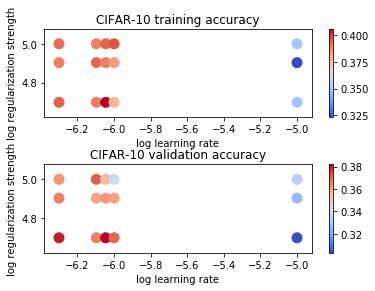

In [76]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [79]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


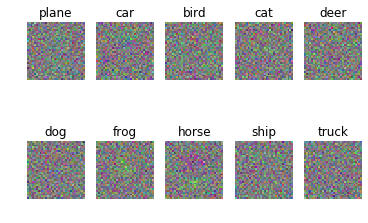

In [80]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
